In [1]:
import tqdm
import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from kaggle_secrets import UserSecretsClient
secret_label = "wandb_api_key"
secret_value = UserSecretsClient().get_secret(secret_label)

import wandb
wandb.login(key=secret_value)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hungbui0416 (project-2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
config = {
    'entity': 'project-2',
    'project': 'CIFAR10-classification',
    'architecture': 'cnn',
    'batch_size': 1024,
    'learning_rate': 3e-4,
    'weight_decay': 1e-4,
    'scheduler': 'cosine',
    'num_epochs': 500
}

# Data Preparing

In [4]:
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [5]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return self.transform(x), y

In [6]:
# train dataset
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None
)

# train/val split
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

# train/val set
train_set = TransformedDataset(dataset=train_dataset, transform=train_transform)
val_set = TransformedDataset(dataset=val_dataset, transform=test_transform)

100%|██████████| 170M/170M [00:02<00:00, 76.7MB/s] 


In [7]:
# test set
test_set = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform
)

In [8]:
# dataloader
train_loader = DataLoader(
    train_set,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Modeling

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

# Training

In [10]:
def batch_log(step, log_freq, loss, optimizer):
    if step % log_freq == 0:
        wandb.log({
            "train/loss": loss,
            "train/lr": optimizer.param_groups[0]['lr'],
        })

def epoch_log(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f"epoch [{epoch:2}/{num_epochs}] train_loss {train_loss:.4f} train_acc {train_acc:.2f}%")
    print(f"epoch [{epoch:2}/{num_epochs}] val_loss {val_loss:.4f} val_acc {val_acc:.2f}%")
    
    wandb.log({
        "train/epoch_loss": train_loss,
        "train/epoch_acc": train_acc,
        "val/epoch_loss": val_loss,
        "val/epoch_acc": val_acc,
        "epoch": epoch
    })

In [11]:
def train(epoch, loader, device, model, criterion, optimizer, scheduler, log_freq):
    model.train()
    
    total_loss = 0
    correct = 0
    total = 0

    for step, (inputs, labels) in enumerate(tqdm.tqdm(loader, desc=f"Train epoch {epoch}")):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        batch_log(step, log_freq, loss.item(), optimizer)

    if scheduler:
        scheduler.step()

    avg_loss = total_loss / total
    acc = 100. * correct / total
    return avg_loss, acc

In [12]:
def validate(epoch, loader, device, model, criterion):
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader, desc=f"Val epoch {epoch}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = 100. * correct / total
    return avg_loss, acc

In [13]:
class EarlyStopper:
    def __init__(self, model, model_dir, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.model = model
        self.model_dir = model_dir
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            print(f'best_val_loss {val_loss:.4f}, save model!')
            torch.save(self.model.state_dict(), self.model_dir)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
model = CNN().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
os.makedirs('./ckpt', exist_ok=True)
model_dir = './ckpt/model.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["num_epochs"])
early_stopper = EarlyStopper(model, model_dir, patience=3, min_delta=0.1)

In [15]:
wandb.init(entity=config['entity'], project=config["project"], config=config)

In [16]:
wandb.watch(model, log="gradients", log_freq=10)

for epoch in range(1, config['num_epochs'] + 1):
    train_loss, train_acc = train(epoch, train_loader, device, model, criterion, optimizer, scheduler, log_freq=10)
    val_loss, val_acc = validate(epoch, val_loader, device, model, criterion)

    epoch_log(epoch, config['num_epochs'], train_loss, train_acc, val_loss, val_acc)

    if early_stopper.early_stop(val_loss):
        print('early stop at epoch', epoch)
        break

artifact = wandb.Artifact('model', type='model')
artifact.add_file(model_dir)
wandb.log_artifact(artifact)

Val epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [ 1/500] train_loss 2.0411 train_acc 24.55%
epoch [ 1/500] val_loss 1.8121 val_acc 32.68%
best_val_loss 1.8121, save model!


Val epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [ 2/500] train_loss 1.7575 train_acc 34.75%
epoch [ 2/500] val_loss 1.5212 val_acc 44.66%
best_val_loss 1.5212, save model!


Val epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


epoch [ 3/500] train_loss 1.6194 train_acc 40.35%
epoch [ 3/500] val_loss 1.4074 val_acc 49.55%
best_val_loss 1.4074, save model!


Val epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


epoch [ 4/500] train_loss 1.5274 train_acc 43.74%
epoch [ 4/500] val_loss 1.2871 val_acc 52.20%
best_val_loss 1.2871, save model!


Val epoch 5: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [ 5/500] train_loss 1.4532 train_acc 47.06%
epoch [ 5/500] val_loss 1.2537 val_acc 54.94%
best_val_loss 1.2537, save model!


Val epoch 6: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


epoch [ 6/500] train_loss 1.3797 train_acc 49.80%
epoch [ 6/500] val_loss 1.1518 val_acc 58.20%
best_val_loss 1.1518, save model!


Val epoch 7: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [ 7/500] train_loss 1.3188 train_acc 52.08%
epoch [ 7/500] val_loss 1.0481 val_acc 62.05%
best_val_loss 1.0481, save model!


Val epoch 8: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [ 8/500] train_loss 1.2602 train_acc 54.51%
epoch [ 8/500] val_loss 1.0405 val_acc 62.13%
best_val_loss 1.0405, save model!


Val epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


epoch [ 9/500] train_loss 1.2087 train_acc 56.76%
epoch [ 9/500] val_loss 0.9662 val_acc 64.62%
best_val_loss 0.9662, save model!


Val epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


epoch [10/500] train_loss 1.1592 train_acc 58.55%
epoch [10/500] val_loss 0.8983 val_acc 67.22%
best_val_loss 0.8983, save model!


Val epoch 11: 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


epoch [11/500] train_loss 1.1278 train_acc 59.95%
epoch [11/500] val_loss 0.8720 val_acc 68.45%
best_val_loss 0.8720, save model!


Val epoch 12: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [12/500] train_loss 1.0882 train_acc 61.30%
epoch [12/500] val_loss 0.8663 val_acc 68.56%
best_val_loss 0.8663, save model!


Val epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


epoch [13/500] train_loss 1.0624 train_acc 62.19%
epoch [13/500] val_loss 0.8143 val_acc 69.98%
best_val_loss 0.8143, save model!


Val epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [14/500] train_loss 1.0310 train_acc 63.64%
epoch [14/500] val_loss 0.7902 val_acc 71.05%
best_val_loss 0.7902, save model!


Val epoch 15: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [15/500] train_loss 1.0043 train_acc 64.85%
epoch [15/500] val_loss 0.7692 val_acc 71.85%
best_val_loss 0.7692, save model!


Val epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [16/500] train_loss 0.9987 train_acc 64.83%
epoch [16/500] val_loss 0.7608 val_acc 72.47%
best_val_loss 0.7608, save model!


Val epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [17/500] train_loss 0.9585 train_acc 66.26%
epoch [17/500] val_loss 0.7528 val_acc 72.60%
best_val_loss 0.7528, save model!


Val epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


epoch [18/500] train_loss 0.9467 train_acc 66.45%
epoch [18/500] val_loss 0.7355 val_acc 73.18%
best_val_loss 0.7355, save model!


Val epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [19/500] train_loss 0.9239 train_acc 67.36%
epoch [19/500] val_loss 0.6992 val_acc 74.77%
best_val_loss 0.6992, save model!


Val epoch 20: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [20/500] train_loss 0.9017 train_acc 68.20%
epoch [20/500] val_loss 0.6805 val_acc 75.50%
best_val_loss 0.6805, save model!


Val epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [21/500] train_loss 0.8815 train_acc 69.11%
epoch [21/500] val_loss 0.6776 val_acc 75.70%
best_val_loss 0.6776, save model!


Val epoch 22: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [22/500] train_loss 0.8678 train_acc 69.34%
epoch [22/500] val_loss 0.6725 val_acc 75.96%
best_val_loss 0.6725, save model!


Val epoch 23: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [23/500] train_loss 0.8608 train_acc 70.09%
epoch [23/500] val_loss 0.6660 val_acc 76.16%
best_val_loss 0.6660, save model!


Val epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


epoch [24/500] train_loss 0.8515 train_acc 70.29%
epoch [24/500] val_loss 0.6591 val_acc 76.26%
best_val_loss 0.6591, save model!


Val epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


epoch [25/500] train_loss 0.8298 train_acc 71.03%
epoch [25/500] val_loss 0.6255 val_acc 77.30%
best_val_loss 0.6255, save model!


Val epoch 26: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [26/500] train_loss 0.8284 train_acc 70.86%
epoch [26/500] val_loss 0.6113 val_acc 78.29%
best_val_loss 0.6113, save model!


Val epoch 27: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


epoch [27/500] train_loss 0.8108 train_acc 71.88%
epoch [27/500] val_loss 0.6477 val_acc 77.01%


Val epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [28/500] train_loss 0.7999 train_acc 72.06%
epoch [28/500] val_loss 0.6217 val_acc 77.66%


Val epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [29/500] train_loss 0.7835 train_acc 72.78%
epoch [29/500] val_loss 0.5857 val_acc 79.08%
best_val_loss 0.5857, save model!


Val epoch 30: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [30/500] train_loss 0.7773 train_acc 72.85%
epoch [30/500] val_loss 0.5846 val_acc 79.23%
best_val_loss 0.5846, save model!


Val epoch 31: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


epoch [31/500] train_loss 0.7677 train_acc 73.47%
epoch [31/500] val_loss 0.5857 val_acc 79.31%


Val epoch 32: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [32/500] train_loss 0.7628 train_acc 73.73%
epoch [32/500] val_loss 0.5731 val_acc 79.44%
best_val_loss 0.5731, save model!


Val epoch 33: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [33/500] train_loss 0.7548 train_acc 73.64%
epoch [33/500] val_loss 0.5757 val_acc 79.34%


Val epoch 34: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [34/500] train_loss 0.7361 train_acc 74.30%
epoch [34/500] val_loss 0.5590 val_acc 80.13%
best_val_loss 0.5590, save model!


Val epoch 35: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [35/500] train_loss 0.7270 train_acc 75.02%
epoch [35/500] val_loss 0.5688 val_acc 79.58%


Val epoch 36: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


epoch [36/500] train_loss 0.7278 train_acc 74.54%
epoch [36/500] val_loss 0.5581 val_acc 80.08%
best_val_loss 0.5581, save model!


Val epoch 37: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [37/500] train_loss 0.7227 train_acc 75.02%
epoch [37/500] val_loss 0.5700 val_acc 79.84%


Val epoch 38: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [38/500] train_loss 0.7082 train_acc 75.61%
epoch [38/500] val_loss 0.5598 val_acc 80.34%


Val epoch 39: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [39/500] train_loss 0.7101 train_acc 75.65%
epoch [39/500] val_loss 0.5348 val_acc 80.93%
best_val_loss 0.5348, save model!


Val epoch 40: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


epoch [40/500] train_loss 0.7037 train_acc 75.72%
epoch [40/500] val_loss 0.5308 val_acc 80.93%
best_val_loss 0.5308, save model!


Val epoch 41: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [41/500] train_loss 0.6937 train_acc 76.18%
epoch [41/500] val_loss 0.5386 val_acc 80.97%


Val epoch 42: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [42/500] train_loss 0.6772 train_acc 76.63%
epoch [42/500] val_loss 0.5189 val_acc 81.72%
best_val_loss 0.5189, save model!


Val epoch 43: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [43/500] train_loss 0.6887 train_acc 76.31%
epoch [43/500] val_loss 0.4980 val_acc 82.08%
best_val_loss 0.4980, save model!


Val epoch 44: 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


epoch [44/500] train_loss 0.6676 train_acc 77.23%
epoch [44/500] val_loss 0.5187 val_acc 81.35%


Val epoch 45: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [45/500] train_loss 0.6658 train_acc 77.14%
epoch [45/500] val_loss 0.5204 val_acc 81.66%


Val epoch 46: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [46/500] train_loss 0.6518 train_acc 77.58%
epoch [46/500] val_loss 0.5011 val_acc 82.26%


Val epoch 47: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [47/500] train_loss 0.6595 train_acc 77.38%
epoch [47/500] val_loss 0.5059 val_acc 82.19%


Val epoch 48: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [48/500] train_loss 0.6485 train_acc 77.72%
epoch [48/500] val_loss 0.5031 val_acc 81.79%


Val epoch 49: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [49/500] train_loss 0.6446 train_acc 77.75%
epoch [49/500] val_loss 0.4945 val_acc 82.02%
best_val_loss 0.4945, save model!


Val epoch 50: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [50/500] train_loss 0.6295 train_acc 77.97%
epoch [50/500] val_loss 0.4950 val_acc 82.32%


Val epoch 51: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [51/500] train_loss 0.6272 train_acc 78.47%
epoch [51/500] val_loss 0.4916 val_acc 82.57%
best_val_loss 0.4916, save model!


Val epoch 52: 100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


epoch [52/500] train_loss 0.6297 train_acc 78.36%
epoch [52/500] val_loss 0.4730 val_acc 83.33%
best_val_loss 0.4730, save model!


Val epoch 53: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [53/500] train_loss 0.6204 train_acc 78.62%
epoch [53/500] val_loss 0.4769 val_acc 83.21%


Val epoch 54: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [54/500] train_loss 0.6220 train_acc 78.62%
epoch [54/500] val_loss 0.4533 val_acc 83.78%
best_val_loss 0.4533, save model!


Val epoch 55: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [55/500] train_loss 0.6145 train_acc 78.83%
epoch [55/500] val_loss 0.4847 val_acc 82.93%


Val epoch 56: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


epoch [56/500] train_loss 0.6121 train_acc 79.12%
epoch [56/500] val_loss 0.4492 val_acc 83.98%
best_val_loss 0.4492, save model!


Val epoch 57: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


epoch [57/500] train_loss 0.6049 train_acc 79.23%
epoch [57/500] val_loss 0.4498 val_acc 84.00%


Val epoch 58: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [58/500] train_loss 0.6031 train_acc 79.36%
epoch [58/500] val_loss 0.4459 val_acc 83.88%
best_val_loss 0.4459, save model!


Val epoch 59: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


epoch [59/500] train_loss 0.6034 train_acc 79.20%
epoch [59/500] val_loss 0.4573 val_acc 83.87%


Val epoch 60: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


epoch [60/500] train_loss 0.5924 train_acc 79.56%
epoch [60/500] val_loss 0.4687 val_acc 83.47%


Val epoch 61: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


epoch [61/500] train_loss 0.5913 train_acc 79.75%
epoch [61/500] val_loss 0.4527 val_acc 83.96%


Val epoch 62: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


epoch [62/500] train_loss 0.5967 train_acc 79.59%
epoch [62/500] val_loss 0.4480 val_acc 84.00%


Val epoch 63: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


epoch [63/500] train_loss 0.5806 train_acc 80.12%
epoch [63/500] val_loss 0.4352 val_acc 84.38%
best_val_loss 0.4352, save model!


Val epoch 64: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [64/500] train_loss 0.5809 train_acc 80.20%
epoch [64/500] val_loss 0.4438 val_acc 84.62%


Val epoch 65: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


epoch [65/500] train_loss 0.5717 train_acc 80.41%
epoch [65/500] val_loss 0.4394 val_acc 84.25%


Val epoch 66: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [66/500] train_loss 0.5668 train_acc 80.48%
epoch [66/500] val_loss 0.4375 val_acc 84.64%


Val epoch 67: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [67/500] train_loss 0.5667 train_acc 80.78%
epoch [67/500] val_loss 0.4359 val_acc 84.51%


Val epoch 68: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [68/500] train_loss 0.5609 train_acc 80.83%
epoch [68/500] val_loss 0.4225 val_acc 85.07%
best_val_loss 0.4225, save model!


Val epoch 69: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [69/500] train_loss 0.5576 train_acc 80.81%
epoch [69/500] val_loss 0.4098 val_acc 85.28%
best_val_loss 0.4098, save model!


Val epoch 70: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [70/500] train_loss 0.5480 train_acc 81.09%
epoch [70/500] val_loss 0.4211 val_acc 85.30%


Val epoch 71: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [71/500] train_loss 0.5529 train_acc 81.06%
epoch [71/500] val_loss 0.4265 val_acc 84.81%


Val epoch 72: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


epoch [72/500] train_loss 0.5477 train_acc 81.36%
epoch [72/500] val_loss 0.4027 val_acc 85.67%
best_val_loss 0.4027, save model!


Val epoch 73: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [73/500] train_loss 0.5439 train_acc 81.36%
epoch [73/500] val_loss 0.4079 val_acc 85.65%


Val epoch 74: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [74/500] train_loss 0.5511 train_acc 81.20%
epoch [74/500] val_loss 0.4031 val_acc 85.52%


Val epoch 75: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [75/500] train_loss 0.5382 train_acc 81.54%
epoch [75/500] val_loss 0.4087 val_acc 85.65%


Val epoch 76: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [76/500] train_loss 0.5346 train_acc 81.64%
epoch [76/500] val_loss 0.4263 val_acc 85.29%


Val epoch 77: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [77/500] train_loss 0.5339 train_acc 81.88%
epoch [77/500] val_loss 0.4041 val_acc 85.63%


Val epoch 78: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


epoch [78/500] train_loss 0.5186 train_acc 82.31%
epoch [78/500] val_loss 0.4060 val_acc 85.53%


Val epoch 79: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [79/500] train_loss 0.5177 train_acc 82.36%
epoch [79/500] val_loss 0.4144 val_acc 85.45%


Val epoch 80: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [80/500] train_loss 0.5265 train_acc 81.99%
epoch [80/500] val_loss 0.4042 val_acc 85.50%


Val epoch 81: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


epoch [81/500] train_loss 0.5056 train_acc 82.53%
epoch [81/500] val_loss 0.4029 val_acc 85.83%


Val epoch 82: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [82/500] train_loss 0.5062 train_acc 82.78%
epoch [82/500] val_loss 0.3917 val_acc 86.26%
best_val_loss 0.3917, save model!


Val epoch 83: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [83/500] train_loss 0.5123 train_acc 82.35%
epoch [83/500] val_loss 0.4020 val_acc 86.02%


Val epoch 84: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


epoch [84/500] train_loss 0.5130 train_acc 82.25%
epoch [84/500] val_loss 0.3898 val_acc 86.29%
best_val_loss 0.3898, save model!


Val epoch 85: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [85/500] train_loss 0.5005 train_acc 82.95%
epoch [85/500] val_loss 0.3980 val_acc 86.09%


Val epoch 86: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [86/500] train_loss 0.4978 train_acc 83.00%
epoch [86/500] val_loss 0.4047 val_acc 85.86%


Val epoch 87: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [87/500] train_loss 0.4980 train_acc 82.93%
epoch [87/500] val_loss 0.3938 val_acc 86.05%


Val epoch 88: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


epoch [88/500] train_loss 0.4960 train_acc 82.98%
epoch [88/500] val_loss 0.3914 val_acc 86.39%


Val epoch 89: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [89/500] train_loss 0.4920 train_acc 83.06%
epoch [89/500] val_loss 0.3918 val_acc 86.22%


Val epoch 90: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [90/500] train_loss 0.4913 train_acc 83.08%
epoch [90/500] val_loss 0.3691 val_acc 87.04%
best_val_loss 0.3691, save model!


Val epoch 91: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [91/500] train_loss 0.4862 train_acc 83.23%
epoch [91/500] val_loss 0.3885 val_acc 86.60%


Val epoch 92: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [92/500] train_loss 0.4882 train_acc 83.19%
epoch [92/500] val_loss 0.3652 val_acc 87.60%
best_val_loss 0.3652, save model!


Val epoch 93: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [93/500] train_loss 0.4880 train_acc 83.26%
epoch [93/500] val_loss 0.3982 val_acc 85.87%


Val epoch 94: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [94/500] train_loss 0.4841 train_acc 83.25%
epoch [94/500] val_loss 0.4288 val_acc 84.79%


Val epoch 95: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


epoch [95/500] train_loss 0.4779 train_acc 83.79%
epoch [95/500] val_loss 0.3666 val_acc 86.90%


Val epoch 96: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [96/500] train_loss 0.4800 train_acc 83.47%
epoch [96/500] val_loss 0.3744 val_acc 87.16%


Val epoch 97: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [97/500] train_loss 0.4833 train_acc 83.63%
epoch [97/500] val_loss 0.3753 val_acc 86.83%


Val epoch 98: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [98/500] train_loss 0.4762 train_acc 83.86%
epoch [98/500] val_loss 0.3828 val_acc 86.68%


Val epoch 99: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [99/500] train_loss 0.4665 train_acc 83.85%
epoch [99/500] val_loss 0.3595 val_acc 87.51%
best_val_loss 0.3595, save model!


Val epoch 100: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [100/500] train_loss 0.4710 train_acc 83.83%
epoch [100/500] val_loss 0.3744 val_acc 86.79%


Val epoch 101: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [101/500] train_loss 0.4737 train_acc 83.62%
epoch [101/500] val_loss 0.3780 val_acc 86.94%


Val epoch 102: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


epoch [102/500] train_loss 0.4778 train_acc 83.69%
epoch [102/500] val_loss 0.3744 val_acc 87.07%


Val epoch 103: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


epoch [103/500] train_loss 0.4643 train_acc 84.08%
epoch [103/500] val_loss 0.3774 val_acc 86.96%


Val epoch 104: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [104/500] train_loss 0.4683 train_acc 83.88%
epoch [104/500] val_loss 0.3643 val_acc 87.26%


Val epoch 105: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [105/500] train_loss 0.4646 train_acc 84.22%
epoch [105/500] val_loss 0.3718 val_acc 86.71%


Val epoch 106: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [106/500] train_loss 0.4651 train_acc 84.00%
epoch [106/500] val_loss 0.3506 val_acc 87.77%
best_val_loss 0.3506, save model!


Val epoch 107: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [107/500] train_loss 0.4513 train_acc 84.38%
epoch [107/500] val_loss 0.3623 val_acc 87.28%


Val epoch 108: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [108/500] train_loss 0.4459 train_acc 84.74%
epoch [108/500] val_loss 0.3660 val_acc 87.13%


Val epoch 109: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


epoch [109/500] train_loss 0.4568 train_acc 84.35%
epoch [109/500] val_loss 0.3641 val_acc 87.46%


Val epoch 110: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [110/500] train_loss 0.4532 train_acc 84.53%
epoch [110/500] val_loss 0.3655 val_acc 86.79%


Val epoch 111: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [111/500] train_loss 0.4527 train_acc 84.55%
epoch [111/500] val_loss 0.3742 val_acc 86.89%


Val epoch 112: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [112/500] train_loss 0.4487 train_acc 84.46%
epoch [112/500] val_loss 0.3676 val_acc 87.51%


Val epoch 113: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [113/500] train_loss 0.4463 train_acc 84.75%
epoch [113/500] val_loss 0.3673 val_acc 87.19%


Val epoch 114: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [114/500] train_loss 0.4449 train_acc 84.86%
epoch [114/500] val_loss 0.3547 val_acc 87.59%


Val epoch 115: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [115/500] train_loss 0.4387 train_acc 84.97%
epoch [115/500] val_loss 0.3612 val_acc 87.57%


Val epoch 116: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [116/500] train_loss 0.4315 train_acc 85.16%
epoch [116/500] val_loss 0.3554 val_acc 87.59%


Val epoch 117: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [117/500] train_loss 0.4302 train_acc 85.36%
epoch [117/500] val_loss 0.3443 val_acc 87.94%
best_val_loss 0.3443, save model!


Val epoch 118: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [118/500] train_loss 0.4297 train_acc 85.38%
epoch [118/500] val_loss 0.3531 val_acc 87.64%


Val epoch 119: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [119/500] train_loss 0.4262 train_acc 85.40%
epoch [119/500] val_loss 0.3401 val_acc 88.24%
best_val_loss 0.3401, save model!


Val epoch 120: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [120/500] train_loss 0.4267 train_acc 85.23%
epoch [120/500] val_loss 0.3507 val_acc 87.72%


Val epoch 121: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [121/500] train_loss 0.4243 train_acc 85.49%
epoch [121/500] val_loss 0.3515 val_acc 88.00%


Val epoch 122: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [122/500] train_loss 0.4262 train_acc 85.39%
epoch [122/500] val_loss 0.3429 val_acc 88.02%


Val epoch 123: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [123/500] train_loss 0.4164 train_acc 85.71%
epoch [123/500] val_loss 0.3690 val_acc 87.62%


Val epoch 124: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [124/500] train_loss 0.4147 train_acc 85.82%
epoch [124/500] val_loss 0.3420 val_acc 88.17%


Val epoch 125: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


epoch [125/500] train_loss 0.4092 train_acc 85.94%
epoch [125/500] val_loss 0.3504 val_acc 87.98%


Val epoch 126: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [126/500] train_loss 0.4100 train_acc 85.90%
epoch [126/500] val_loss 0.3485 val_acc 87.65%


Val epoch 127: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


epoch [127/500] train_loss 0.4182 train_acc 85.56%
epoch [127/500] val_loss 0.3372 val_acc 88.29%
best_val_loss 0.3372, save model!


Val epoch 128: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [128/500] train_loss 0.4077 train_acc 86.15%
epoch [128/500] val_loss 0.3360 val_acc 88.26%
best_val_loss 0.3360, save model!


Val epoch 129: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [129/500] train_loss 0.3998 train_acc 86.25%
epoch [129/500] val_loss 0.3447 val_acc 87.92%


Val epoch 130: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [130/500] train_loss 0.4038 train_acc 86.14%
epoch [130/500] val_loss 0.3406 val_acc 88.01%


Val epoch 131: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [131/500] train_loss 0.4033 train_acc 86.20%
epoch [131/500] val_loss 0.3374 val_acc 88.24%


Val epoch 132: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [132/500] train_loss 0.4010 train_acc 86.45%
epoch [132/500] val_loss 0.3396 val_acc 88.14%


Val epoch 133: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [133/500] train_loss 0.3980 train_acc 86.34%
epoch [133/500] val_loss 0.3415 val_acc 87.92%


Val epoch 134: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


epoch [134/500] train_loss 0.4035 train_acc 86.40%
epoch [134/500] val_loss 0.3437 val_acc 88.21%


Val epoch 135: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [135/500] train_loss 0.4075 train_acc 86.08%
epoch [135/500] val_loss 0.3439 val_acc 88.26%


Val epoch 136: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [136/500] train_loss 0.4062 train_acc 86.33%
epoch [136/500] val_loss 0.3355 val_acc 88.38%
best_val_loss 0.3355, save model!


Val epoch 137: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [137/500] train_loss 0.3953 train_acc 86.24%
epoch [137/500] val_loss 0.3425 val_acc 88.16%


Val epoch 138: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [138/500] train_loss 0.3952 train_acc 86.31%
epoch [138/500] val_loss 0.3374 val_acc 88.38%


Val epoch 139: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [139/500] train_loss 0.3898 train_acc 86.53%
epoch [139/500] val_loss 0.3315 val_acc 88.43%
best_val_loss 0.3315, save model!


Val epoch 140: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [140/500] train_loss 0.3902 train_acc 86.76%
epoch [140/500] val_loss 0.3258 val_acc 88.60%
best_val_loss 0.3258, save model!


Val epoch 141: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


epoch [141/500] train_loss 0.3919 train_acc 86.77%
epoch [141/500] val_loss 0.3524 val_acc 88.00%


Val epoch 142: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


epoch [142/500] train_loss 0.3923 train_acc 86.64%
epoch [142/500] val_loss 0.3432 val_acc 88.20%


Val epoch 143: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [143/500] train_loss 0.3866 train_acc 86.64%
epoch [143/500] val_loss 0.3464 val_acc 88.05%


Val epoch 144: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [144/500] train_loss 0.3905 train_acc 86.61%
epoch [144/500] val_loss 0.3252 val_acc 88.85%
best_val_loss 0.3252, save model!


Val epoch 145: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [145/500] train_loss 0.3812 train_acc 86.97%
epoch [145/500] val_loss 0.3236 val_acc 88.73%
best_val_loss 0.3236, save model!


Val epoch 146: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


epoch [146/500] train_loss 0.3782 train_acc 86.92%
epoch [146/500] val_loss 0.3272 val_acc 88.57%


Val epoch 147: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [147/500] train_loss 0.3906 train_acc 86.59%
epoch [147/500] val_loss 0.3365 val_acc 88.39%


Val epoch 148: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [148/500] train_loss 0.3862 train_acc 86.77%
epoch [148/500] val_loss 0.3324 val_acc 88.76%


Val epoch 149: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [149/500] train_loss 0.3855 train_acc 86.70%
epoch [149/500] val_loss 0.3329 val_acc 88.40%


Val epoch 150: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [150/500] train_loss 0.3729 train_acc 87.21%
epoch [150/500] val_loss 0.3156 val_acc 89.16%
best_val_loss 0.3156, save model!


Val epoch 151: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [151/500] train_loss 0.3826 train_acc 87.02%
epoch [151/500] val_loss 0.3344 val_acc 88.42%


Val epoch 152: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [152/500] train_loss 0.3734 train_acc 87.19%
epoch [152/500] val_loss 0.3206 val_acc 88.80%


Val epoch 153: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [153/500] train_loss 0.3699 train_acc 87.41%
epoch [153/500] val_loss 0.3198 val_acc 88.82%


Val epoch 154: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


epoch [154/500] train_loss 0.3714 train_acc 87.42%
epoch [154/500] val_loss 0.3309 val_acc 88.84%


Val epoch 155: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [155/500] train_loss 0.3715 train_acc 87.33%
epoch [155/500] val_loss 0.3187 val_acc 89.01%


Val epoch 156: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [156/500] train_loss 0.3664 train_acc 87.35%
epoch [156/500] val_loss 0.3143 val_acc 89.07%
best_val_loss 0.3143, save model!


Val epoch 157: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [157/500] train_loss 0.3692 train_acc 87.40%
epoch [157/500] val_loss 0.3143 val_acc 88.88%


Val epoch 158: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [158/500] train_loss 0.3716 train_acc 87.25%
epoch [158/500] val_loss 0.3133 val_acc 88.92%
best_val_loss 0.3133, save model!


Val epoch 159: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


epoch [159/500] train_loss 0.3612 train_acc 87.47%
epoch [159/500] val_loss 0.3382 val_acc 88.34%


Val epoch 160: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [160/500] train_loss 0.3610 train_acc 87.60%
epoch [160/500] val_loss 0.3288 val_acc 88.67%


Val epoch 161: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [161/500] train_loss 0.3580 train_acc 87.55%
epoch [161/500] val_loss 0.3199 val_acc 88.84%


Val epoch 162: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [162/500] train_loss 0.3499 train_acc 87.95%
epoch [162/500] val_loss 0.3227 val_acc 88.77%


Val epoch 163: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [163/500] train_loss 0.3531 train_acc 88.02%
epoch [163/500] val_loss 0.3145 val_acc 89.01%


Val epoch 164: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


epoch [164/500] train_loss 0.3573 train_acc 87.60%
epoch [164/500] val_loss 0.3123 val_acc 89.33%
best_val_loss 0.3123, save model!


Val epoch 165: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [165/500] train_loss 0.3626 train_acc 87.58%
epoch [165/500] val_loss 0.3164 val_acc 89.16%


Val epoch 166: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


epoch [166/500] train_loss 0.3646 train_acc 87.55%
epoch [166/500] val_loss 0.3234 val_acc 88.69%


Val epoch 167: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [167/500] train_loss 0.3583 train_acc 87.74%
epoch [167/500] val_loss 0.3043 val_acc 89.43%
best_val_loss 0.3043, save model!


Val epoch 168: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [168/500] train_loss 0.3584 train_acc 87.61%
epoch [168/500] val_loss 0.3134 val_acc 89.09%


Val epoch 169: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [169/500] train_loss 0.3540 train_acc 87.73%
epoch [169/500] val_loss 0.3215 val_acc 88.88%


Val epoch 170: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [170/500] train_loss 0.3476 train_acc 88.18%
epoch [170/500] val_loss 0.3091 val_acc 89.39%


Val epoch 171: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [171/500] train_loss 0.3462 train_acc 88.11%
epoch [171/500] val_loss 0.3219 val_acc 89.12%


Val epoch 172: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [172/500] train_loss 0.3564 train_acc 87.79%
epoch [172/500] val_loss 0.3138 val_acc 89.05%


Val epoch 173: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [173/500] train_loss 0.3474 train_acc 87.98%
epoch [173/500] val_loss 0.3102 val_acc 89.30%


Val epoch 174: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [174/500] train_loss 0.3490 train_acc 88.10%
epoch [174/500] val_loss 0.3119 val_acc 89.18%


Val epoch 175: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [175/500] train_loss 0.3504 train_acc 87.97%
epoch [175/500] val_loss 0.3149 val_acc 89.38%


Val epoch 176: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [176/500] train_loss 0.3461 train_acc 88.07%
epoch [176/500] val_loss 0.3193 val_acc 89.07%


Val epoch 177: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [177/500] train_loss 0.3372 train_acc 88.53%
epoch [177/500] val_loss 0.3205 val_acc 88.80%


Val epoch 178: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [178/500] train_loss 0.3361 train_acc 88.50%
epoch [178/500] val_loss 0.3083 val_acc 89.12%


Val epoch 179: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [179/500] train_loss 0.3475 train_acc 88.08%
epoch [179/500] val_loss 0.3122 val_acc 89.29%


Val epoch 180: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [180/500] train_loss 0.3385 train_acc 88.42%
epoch [180/500] val_loss 0.3057 val_acc 89.57%


Val epoch 181: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [181/500] train_loss 0.3388 train_acc 88.39%
epoch [181/500] val_loss 0.3080 val_acc 89.58%


Val epoch 182: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


epoch [182/500] train_loss 0.3279 train_acc 88.68%
epoch [182/500] val_loss 0.3155 val_acc 89.11%


Val epoch 183: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [183/500] train_loss 0.3362 train_acc 88.47%
epoch [183/500] val_loss 0.3020 val_acc 89.75%
best_val_loss 0.3020, save model!


Val epoch 184: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


epoch [184/500] train_loss 0.3334 train_acc 88.58%
epoch [184/500] val_loss 0.3329 val_acc 88.60%


Val epoch 185: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


epoch [185/500] train_loss 0.3320 train_acc 88.54%
epoch [185/500] val_loss 0.2951 val_acc 89.94%
best_val_loss 0.2951, save model!


Val epoch 186: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [186/500] train_loss 0.3324 train_acc 88.62%
epoch [186/500] val_loss 0.3078 val_acc 89.66%


Val epoch 187: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [187/500] train_loss 0.3258 train_acc 88.70%
epoch [187/500] val_loss 0.3025 val_acc 89.86%


Val epoch 188: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [188/500] train_loss 0.3328 train_acc 88.52%
epoch [188/500] val_loss 0.3162 val_acc 89.29%


Val epoch 189: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [189/500] train_loss 0.3299 train_acc 88.72%
epoch [189/500] val_loss 0.3056 val_acc 89.57%


Val epoch 190: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [190/500] train_loss 0.3245 train_acc 88.85%
epoch [190/500] val_loss 0.3018 val_acc 89.64%


Val epoch 191: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


epoch [191/500] train_loss 0.3244 train_acc 88.87%
epoch [191/500] val_loss 0.3095 val_acc 89.31%


Val epoch 192: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [192/500] train_loss 0.3170 train_acc 89.18%
epoch [192/500] val_loss 0.2883 val_acc 89.90%
best_val_loss 0.2883, save model!


Val epoch 193: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [193/500] train_loss 0.3186 train_acc 89.04%
epoch [193/500] val_loss 0.3033 val_acc 89.64%


Val epoch 194: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [194/500] train_loss 0.3252 train_acc 88.70%
epoch [194/500] val_loss 0.3014 val_acc 89.91%


Val epoch 195: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [195/500] train_loss 0.3163 train_acc 89.19%
epoch [195/500] val_loss 0.3047 val_acc 89.86%


Val epoch 196: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [196/500] train_loss 0.3155 train_acc 89.13%
epoch [196/500] val_loss 0.3144 val_acc 89.17%


Val epoch 197: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [197/500] train_loss 0.3179 train_acc 88.98%
epoch [197/500] val_loss 0.3077 val_acc 89.54%


Val epoch 198: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


epoch [198/500] train_loss 0.3165 train_acc 89.26%
epoch [198/500] val_loss 0.3053 val_acc 89.65%


Val epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [199/500] train_loss 0.3197 train_acc 88.92%
epoch [199/500] val_loss 0.2914 val_acc 89.83%


Val epoch 200: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [200/500] train_loss 0.3188 train_acc 89.14%
epoch [200/500] val_loss 0.2939 val_acc 89.81%


Val epoch 201: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [201/500] train_loss 0.3158 train_acc 89.05%
epoch [201/500] val_loss 0.2983 val_acc 89.87%


Val epoch 202: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [202/500] train_loss 0.3172 train_acc 89.07%
epoch [202/500] val_loss 0.2913 val_acc 89.92%


Val epoch 203: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [203/500] train_loss 0.3082 train_acc 89.47%
epoch [203/500] val_loss 0.2911 val_acc 89.90%


Val epoch 204: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [204/500] train_loss 0.3089 train_acc 89.26%
epoch [204/500] val_loss 0.3001 val_acc 89.70%


Val epoch 205: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


epoch [205/500] train_loss 0.3082 train_acc 89.45%
epoch [205/500] val_loss 0.2880 val_acc 90.22%
best_val_loss 0.2880, save model!


Val epoch 206: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [206/500] train_loss 0.3034 train_acc 89.65%
epoch [206/500] val_loss 0.2915 val_acc 89.85%


Val epoch 207: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [207/500] train_loss 0.3080 train_acc 89.46%
epoch [207/500] val_loss 0.2954 val_acc 90.06%


Val epoch 208: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [208/500] train_loss 0.3102 train_acc 89.33%
epoch [208/500] val_loss 0.2915 val_acc 90.27%


Val epoch 209: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [209/500] train_loss 0.3103 train_acc 89.37%
epoch [209/500] val_loss 0.2963 val_acc 90.08%


Val epoch 210: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [210/500] train_loss 0.3068 train_acc 89.37%
epoch [210/500] val_loss 0.3018 val_acc 89.87%


Val epoch 211: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [211/500] train_loss 0.3128 train_acc 89.14%
epoch [211/500] val_loss 0.2932 val_acc 90.04%


Val epoch 212: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [212/500] train_loss 0.3031 train_acc 89.65%
epoch [212/500] val_loss 0.2981 val_acc 89.75%


Val epoch 213: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [213/500] train_loss 0.3042 train_acc 89.42%
epoch [213/500] val_loss 0.2956 val_acc 89.93%


Val epoch 214: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [214/500] train_loss 0.3081 train_acc 89.30%
epoch [214/500] val_loss 0.2913 val_acc 89.98%


Val epoch 215: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [215/500] train_loss 0.2976 train_acc 89.70%
epoch [215/500] val_loss 0.2968 val_acc 89.86%


Val epoch 216: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [216/500] train_loss 0.2964 train_acc 89.83%
epoch [216/500] val_loss 0.2932 val_acc 90.23%


Val epoch 217: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [217/500] train_loss 0.3017 train_acc 89.62%
epoch [217/500] val_loss 0.3056 val_acc 89.42%


Val epoch 218: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [218/500] train_loss 0.3012 train_acc 89.66%
epoch [218/500] val_loss 0.2854 val_acc 90.07%
best_val_loss 0.2854, save model!


Val epoch 219: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [219/500] train_loss 0.2997 train_acc 89.69%
epoch [219/500] val_loss 0.2900 val_acc 89.97%


Val epoch 220: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [220/500] train_loss 0.2970 train_acc 89.75%
epoch [220/500] val_loss 0.2812 val_acc 90.26%
best_val_loss 0.2812, save model!


Val epoch 221: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [221/500] train_loss 0.2913 train_acc 89.92%
epoch [221/500] val_loss 0.2911 val_acc 90.32%


Val epoch 222: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [222/500] train_loss 0.2940 train_acc 89.93%
epoch [222/500] val_loss 0.3062 val_acc 89.71%


Val epoch 223: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [223/500] train_loss 0.2960 train_acc 89.70%
epoch [223/500] val_loss 0.2952 val_acc 90.29%


Val epoch 224: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [224/500] train_loss 0.2893 train_acc 90.07%
epoch [224/500] val_loss 0.2937 val_acc 90.05%


Val epoch 225: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [225/500] train_loss 0.2882 train_acc 90.06%
epoch [225/500] val_loss 0.2872 val_acc 90.36%


Val epoch 226: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [226/500] train_loss 0.2907 train_acc 89.91%
epoch [226/500] val_loss 0.2914 val_acc 90.19%


Val epoch 227: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


epoch [227/500] train_loss 0.2859 train_acc 90.17%
epoch [227/500] val_loss 0.2857 val_acc 90.25%


Val epoch 228: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [228/500] train_loss 0.2883 train_acc 90.01%
epoch [228/500] val_loss 0.3014 val_acc 89.95%


Val epoch 229: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


epoch [229/500] train_loss 0.2997 train_acc 89.73%
epoch [229/500] val_loss 0.2937 val_acc 90.03%


Val epoch 230: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [230/500] train_loss 0.2841 train_acc 90.19%
epoch [230/500] val_loss 0.2751 val_acc 90.63%
best_val_loss 0.2751, save model!


Val epoch 231: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


epoch [231/500] train_loss 0.2834 train_acc 90.22%
epoch [231/500] val_loss 0.2963 val_acc 90.34%


Val epoch 232: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [232/500] train_loss 0.2810 train_acc 90.30%
epoch [232/500] val_loss 0.2907 val_acc 90.34%


Val epoch 233: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [233/500] train_loss 0.2805 train_acc 90.20%
epoch [233/500] val_loss 0.2945 val_acc 90.29%


Val epoch 234: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [234/500] train_loss 0.2806 train_acc 90.19%
epoch [234/500] val_loss 0.2969 val_acc 90.04%


Val epoch 235: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [235/500] train_loss 0.2867 train_acc 90.14%
epoch [235/500] val_loss 0.2992 val_acc 90.17%


Val epoch 236: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [236/500] train_loss 0.2902 train_acc 89.92%
epoch [236/500] val_loss 0.2938 val_acc 90.21%


Val epoch 237: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [237/500] train_loss 0.2837 train_acc 90.22%
epoch [237/500] val_loss 0.3012 val_acc 90.18%


Val epoch 238: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [238/500] train_loss 0.2829 train_acc 90.12%
epoch [238/500] val_loss 0.2947 val_acc 90.23%


Val epoch 239: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


epoch [239/500] train_loss 0.2795 train_acc 90.36%
epoch [239/500] val_loss 0.2818 val_acc 90.88%


Val epoch 240: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [240/500] train_loss 0.2751 train_acc 90.58%
epoch [240/500] val_loss 0.2839 val_acc 90.76%


Val epoch 241: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [241/500] train_loss 0.2778 train_acc 90.31%
epoch [241/500] val_loss 0.3022 val_acc 90.17%


Val epoch 242: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


epoch [242/500] train_loss 0.2712 train_acc 90.53%
epoch [242/500] val_loss 0.2812 val_acc 90.72%


Val epoch 243: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [243/500] train_loss 0.2760 train_acc 90.54%
epoch [243/500] val_loss 0.2992 val_acc 90.21%


Val epoch 244: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


epoch [244/500] train_loss 0.2692 train_acc 90.56%
epoch [244/500] val_loss 0.2815 val_acc 90.60%


Val epoch 245: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [245/500] train_loss 0.2675 train_acc 90.75%
epoch [245/500] val_loss 0.2828 val_acc 90.57%


Val epoch 246: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [246/500] train_loss 0.2666 train_acc 90.83%
epoch [246/500] val_loss 0.2752 val_acc 90.71%


Val epoch 247: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [247/500] train_loss 0.2777 train_acc 90.45%
epoch [247/500] val_loss 0.2840 val_acc 90.43%


Val epoch 248: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [248/500] train_loss 0.2661 train_acc 90.75%
epoch [248/500] val_loss 0.2854 val_acc 90.54%


Val epoch 249: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [249/500] train_loss 0.2723 train_acc 90.61%
epoch [249/500] val_loss 0.2929 val_acc 90.30%


Val epoch 250: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [250/500] train_loss 0.2752 train_acc 90.39%
epoch [250/500] val_loss 0.2875 val_acc 90.41%


Val epoch 251: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


epoch [251/500] train_loss 0.2731 train_acc 90.59%
epoch [251/500] val_loss 0.2907 val_acc 90.37%


Val epoch 252: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [252/500] train_loss 0.2643 train_acc 90.94%
epoch [252/500] val_loss 0.2823 val_acc 90.59%


Val epoch 253: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [253/500] train_loss 0.2669 train_acc 90.77%
epoch [253/500] val_loss 0.2771 val_acc 91.14%


Val epoch 254: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


epoch [254/500] train_loss 0.2681 train_acc 90.70%
epoch [254/500] val_loss 0.2961 val_acc 90.26%


Val epoch 255: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [255/500] train_loss 0.2658 train_acc 90.88%
epoch [255/500] val_loss 0.2919 val_acc 90.50%


Val epoch 256: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [256/500] train_loss 0.2682 train_acc 90.78%
epoch [256/500] val_loss 0.2831 val_acc 90.63%


Val epoch 257: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [257/500] train_loss 0.2629 train_acc 90.91%
epoch [257/500] val_loss 0.2935 val_acc 90.21%


Val epoch 258: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


epoch [258/500] train_loss 0.2649 train_acc 91.00%
epoch [258/500] val_loss 0.2762 val_acc 90.82%


Val epoch 259: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [259/500] train_loss 0.2671 train_acc 90.84%
epoch [259/500] val_loss 0.2747 val_acc 91.01%
best_val_loss 0.2747, save model!


Val epoch 260: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [260/500] train_loss 0.2669 train_acc 90.89%
epoch [260/500] val_loss 0.2826 val_acc 90.53%


Val epoch 261: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [261/500] train_loss 0.2589 train_acc 91.01%
epoch [261/500] val_loss 0.2928 val_acc 90.37%


Val epoch 262: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [262/500] train_loss 0.2546 train_acc 91.16%
epoch [262/500] val_loss 0.2903 val_acc 90.55%


Val epoch 263: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [263/500] train_loss 0.2588 train_acc 91.00%
epoch [263/500] val_loss 0.2842 val_acc 90.50%


Val epoch 264: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [264/500] train_loss 0.2615 train_acc 90.94%
epoch [264/500] val_loss 0.2815 val_acc 90.51%


Val epoch 265: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


epoch [265/500] train_loss 0.2575 train_acc 91.06%
epoch [265/500] val_loss 0.2798 val_acc 90.64%


Val epoch 266: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [266/500] train_loss 0.2571 train_acc 91.06%
epoch [266/500] val_loss 0.2828 val_acc 90.55%


Val epoch 267: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [267/500] train_loss 0.2587 train_acc 91.00%
epoch [267/500] val_loss 0.2776 val_acc 90.77%


Val epoch 268: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [268/500] train_loss 0.2540 train_acc 91.22%
epoch [268/500] val_loss 0.2788 val_acc 90.90%


Val epoch 269: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [269/500] train_loss 0.2544 train_acc 91.18%
epoch [269/500] val_loss 0.2766 val_acc 90.81%


Val epoch 270: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [270/500] train_loss 0.2632 train_acc 90.77%
epoch [270/500] val_loss 0.2810 val_acc 90.71%


Val epoch 271: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [271/500] train_loss 0.2554 train_acc 91.10%
epoch [271/500] val_loss 0.2914 val_acc 90.64%


Val epoch 272: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


epoch [272/500] train_loss 0.2517 train_acc 91.33%
epoch [272/500] val_loss 0.2882 val_acc 90.43%


Val epoch 273: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [273/500] train_loss 0.2550 train_acc 91.14%
epoch [273/500] val_loss 0.2949 val_acc 90.55%


Val epoch 274: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [274/500] train_loss 0.2515 train_acc 91.31%
epoch [274/500] val_loss 0.2794 val_acc 90.64%


Val epoch 275: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [275/500] train_loss 0.2510 train_acc 91.38%
epoch [275/500] val_loss 0.2893 val_acc 90.61%


Val epoch 276: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [276/500] train_loss 0.2501 train_acc 91.48%
epoch [276/500] val_loss 0.2801 val_acc 90.56%


Val epoch 277: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [277/500] train_loss 0.2507 train_acc 91.33%
epoch [277/500] val_loss 0.2747 val_acc 90.88%
best_val_loss 0.2747, save model!


Val epoch 278: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [278/500] train_loss 0.2487 train_acc 91.35%
epoch [278/500] val_loss 0.2870 val_acc 90.56%


Val epoch 279: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [279/500] train_loss 0.2455 train_acc 91.58%
epoch [279/500] val_loss 0.2817 val_acc 90.99%


Val epoch 280: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [280/500] train_loss 0.2522 train_acc 91.16%
epoch [280/500] val_loss 0.2717 val_acc 91.26%
best_val_loss 0.2717, save model!


Val epoch 281: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [281/500] train_loss 0.2442 train_acc 91.43%
epoch [281/500] val_loss 0.2843 val_acc 90.87%


Val epoch 282: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [282/500] train_loss 0.2441 train_acc 91.51%
epoch [282/500] val_loss 0.2776 val_acc 90.96%


Val epoch 283: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


epoch [283/500] train_loss 0.2411 train_acc 91.55%
epoch [283/500] val_loss 0.2871 val_acc 90.77%


Val epoch 284: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [284/500] train_loss 0.2519 train_acc 91.28%
epoch [284/500] val_loss 0.2795 val_acc 90.94%


Val epoch 286: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


epoch [286/500] train_loss 0.2505 train_acc 91.34%
epoch [286/500] val_loss 0.2867 val_acc 90.82%


Val epoch 287: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [287/500] train_loss 0.2463 train_acc 91.49%
epoch [287/500] val_loss 0.2683 val_acc 91.10%
best_val_loss 0.2683, save model!


Val epoch 288: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [288/500] train_loss 0.2415 train_acc 91.58%
epoch [288/500] val_loss 0.2801 val_acc 90.63%


Val epoch 289: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [289/500] train_loss 0.2414 train_acc 91.77%
epoch [289/500] val_loss 0.2837 val_acc 90.75%


Val epoch 290: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [290/500] train_loss 0.2415 train_acc 91.60%
epoch [290/500] val_loss 0.2749 val_acc 91.05%


Val epoch 291: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [291/500] train_loss 0.2383 train_acc 91.78%
epoch [291/500] val_loss 0.2756 val_acc 91.01%


Val epoch 292: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [292/500] train_loss 0.2417 train_acc 91.64%
epoch [292/500] val_loss 0.2880 val_acc 90.69%


Val epoch 293: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [293/500] train_loss 0.2387 train_acc 91.88%
epoch [293/500] val_loss 0.2734 val_acc 91.15%


Val epoch 294: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [294/500] train_loss 0.2367 train_acc 91.96%
epoch [294/500] val_loss 0.2738 val_acc 91.03%


Val epoch 295: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [295/500] train_loss 0.2374 train_acc 91.89%
epoch [295/500] val_loss 0.2753 val_acc 90.88%


Val epoch 296: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [296/500] train_loss 0.2398 train_acc 91.69%
epoch [296/500] val_loss 0.2715 val_acc 91.15%


Val epoch 297: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


epoch [297/500] train_loss 0.2360 train_acc 91.91%
epoch [297/500] val_loss 0.2745 val_acc 90.96%


Val epoch 298: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [298/500] train_loss 0.2334 train_acc 91.88%
epoch [298/500] val_loss 0.2792 val_acc 90.88%


Val epoch 299: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [299/500] train_loss 0.2319 train_acc 92.02%
epoch [299/500] val_loss 0.2752 val_acc 91.15%


Val epoch 300: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [300/500] train_loss 0.2353 train_acc 91.76%
epoch [300/500] val_loss 0.2861 val_acc 90.75%


Val epoch 301: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [301/500] train_loss 0.2350 train_acc 91.87%
epoch [301/500] val_loss 0.2733 val_acc 91.07%


Val epoch 302: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [302/500] train_loss 0.2316 train_acc 91.90%
epoch [302/500] val_loss 0.2696 val_acc 91.14%


Val epoch 303: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [303/500] train_loss 0.2299 train_acc 91.94%
epoch [303/500] val_loss 0.2752 val_acc 90.94%


Val epoch 304: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


epoch [304/500] train_loss 0.2326 train_acc 91.97%
epoch [304/500] val_loss 0.2760 val_acc 91.17%


Val epoch 305: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [305/500] train_loss 0.2271 train_acc 92.20%
epoch [305/500] val_loss 0.2839 val_acc 90.81%


Val epoch 306: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


epoch [306/500] train_loss 0.2208 train_acc 92.32%
epoch [306/500] val_loss 0.2919 val_acc 90.73%


Val epoch 307: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [307/500] train_loss 0.2322 train_acc 91.95%
epoch [307/500] val_loss 0.2701 val_acc 91.12%


Val epoch 308: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [308/500] train_loss 0.2288 train_acc 92.12%
epoch [308/500] val_loss 0.2761 val_acc 91.28%


Val epoch 309: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [309/500] train_loss 0.2281 train_acc 92.04%
epoch [309/500] val_loss 0.2728 val_acc 91.19%


Val epoch 310: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [310/500] train_loss 0.2258 train_acc 92.10%
epoch [310/500] val_loss 0.2704 val_acc 91.23%


Val epoch 311: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


epoch [311/500] train_loss 0.2226 train_acc 92.34%
epoch [311/500] val_loss 0.2712 val_acc 91.33%


Val epoch 312: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [312/500] train_loss 0.2235 train_acc 92.23%
epoch [312/500] val_loss 0.2791 val_acc 90.87%


Val epoch 313: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


epoch [313/500] train_loss 0.2303 train_acc 92.06%
epoch [313/500] val_loss 0.2689 val_acc 91.12%


Val epoch 314: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [314/500] train_loss 0.2191 train_acc 92.25%
epoch [314/500] val_loss 0.2716 val_acc 91.28%


Val epoch 315: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [315/500] train_loss 0.2231 train_acc 92.27%
epoch [315/500] val_loss 0.2677 val_acc 91.31%
best_val_loss 0.2677, save model!


Val epoch 316: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [316/500] train_loss 0.2269 train_acc 92.14%
epoch [316/500] val_loss 0.2727 val_acc 91.29%


Val epoch 317: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [317/500] train_loss 0.2229 train_acc 92.39%
epoch [317/500] val_loss 0.2720 val_acc 91.21%


Val epoch 318: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


epoch [318/500] train_loss 0.2267 train_acc 92.09%
epoch [318/500] val_loss 0.2797 val_acc 91.09%


Val epoch 319: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [319/500] train_loss 0.2225 train_acc 92.24%
epoch [319/500] val_loss 0.2734 val_acc 91.20%


Val epoch 320: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [320/500] train_loss 0.2243 train_acc 92.24%
epoch [320/500] val_loss 0.2716 val_acc 91.38%


Val epoch 321: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [321/500] train_loss 0.2195 train_acc 92.48%
epoch [321/500] val_loss 0.2703 val_acc 91.29%


Val epoch 322: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [322/500] train_loss 0.2195 train_acc 92.44%
epoch [322/500] val_loss 0.2685 val_acc 91.36%


Val epoch 323: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [323/500] train_loss 0.2140 train_acc 92.61%
epoch [323/500] val_loss 0.2815 val_acc 91.07%


Val epoch 324: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [324/500] train_loss 0.2148 train_acc 92.52%
epoch [324/500] val_loss 0.2791 val_acc 91.12%


Val epoch 325: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


epoch [325/500] train_loss 0.2156 train_acc 92.46%
epoch [325/500] val_loss 0.2810 val_acc 91.21%


Val epoch 326: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [326/500] train_loss 0.2151 train_acc 92.57%
epoch [326/500] val_loss 0.2750 val_acc 91.13%


Val epoch 327: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [327/500] train_loss 0.2155 train_acc 92.58%
epoch [327/500] val_loss 0.2779 val_acc 90.98%


Val epoch 328: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [328/500] train_loss 0.2144 train_acc 92.56%
epoch [328/500] val_loss 0.2769 val_acc 91.19%


Val epoch 329: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


epoch [329/500] train_loss 0.2154 train_acc 92.50%
epoch [329/500] val_loss 0.2703 val_acc 91.20%


Val epoch 330: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


epoch [330/500] train_loss 0.2182 train_acc 92.40%
epoch [330/500] val_loss 0.2744 val_acc 91.26%


Val epoch 331: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [331/500] train_loss 0.2153 train_acc 92.55%
epoch [331/500] val_loss 0.2717 val_acc 91.24%


Val epoch 332: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [332/500] train_loss 0.2159 train_acc 92.53%
epoch [332/500] val_loss 0.2822 val_acc 90.93%


Val epoch 333: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


epoch [333/500] train_loss 0.2147 train_acc 92.51%
epoch [333/500] val_loss 0.2718 val_acc 91.33%


Val epoch 334: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


epoch [334/500] train_loss 0.2140 train_acc 92.52%
epoch [334/500] val_loss 0.2745 val_acc 91.33%


Val epoch 335: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


epoch [335/500] train_loss 0.2138 train_acc 92.58%
epoch [335/500] val_loss 0.2721 val_acc 91.31%


Val epoch 336: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [336/500] train_loss 0.2150 train_acc 92.53%
epoch [336/500] val_loss 0.2722 val_acc 91.26%


Val epoch 337: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


epoch [337/500] train_loss 0.2089 train_acc 92.78%
epoch [337/500] val_loss 0.2705 val_acc 91.26%


Val epoch 338: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


epoch [338/500] train_loss 0.2166 train_acc 92.42%
epoch [338/500] val_loss 0.2739 val_acc 91.16%


Val epoch 339: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


epoch [339/500] train_loss 0.2085 train_acc 92.77%
epoch [339/500] val_loss 0.2689 val_acc 91.33%


Val epoch 340: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [340/500] train_loss 0.2140 train_acc 92.36%
epoch [340/500] val_loss 0.2673 val_acc 91.24%
best_val_loss 0.2673, save model!


Val epoch 341: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [341/500] train_loss 0.2146 train_acc 92.47%
epoch [341/500] val_loss 0.2770 val_acc 91.31%


Val epoch 342: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [342/500] train_loss 0.2099 train_acc 92.56%
epoch [342/500] val_loss 0.2792 val_acc 90.98%


Val epoch 343: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [343/500] train_loss 0.2097 train_acc 92.66%
epoch [343/500] val_loss 0.2727 val_acc 91.18%


Val epoch 344: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [344/500] train_loss 0.2095 train_acc 92.82%
epoch [344/500] val_loss 0.2771 val_acc 90.88%


Val epoch 345: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [345/500] train_loss 0.2075 train_acc 92.75%
epoch [345/500] val_loss 0.2768 val_acc 91.03%


Val epoch 346: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [346/500] train_loss 0.2122 train_acc 92.64%
epoch [346/500] val_loss 0.2745 val_acc 91.30%


Val epoch 347: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [347/500] train_loss 0.2074 train_acc 92.86%
epoch [347/500] val_loss 0.2718 val_acc 91.15%


Val epoch 348: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [348/500] train_loss 0.2071 train_acc 92.72%
epoch [348/500] val_loss 0.2717 val_acc 91.20%


Val epoch 349: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [349/500] train_loss 0.2063 train_acc 92.92%
epoch [349/500] val_loss 0.2757 val_acc 91.28%


Val epoch 350: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [350/500] train_loss 0.2092 train_acc 92.71%
epoch [350/500] val_loss 0.2673 val_acc 91.57%
best_val_loss 0.2673, save model!


Val epoch 351: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [351/500] train_loss 0.2078 train_acc 92.84%
epoch [351/500] val_loss 0.2729 val_acc 91.16%


Val epoch 352: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [352/500] train_loss 0.2013 train_acc 93.00%
epoch [352/500] val_loss 0.2693 val_acc 91.42%


Val epoch 353: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [353/500] train_loss 0.2058 train_acc 92.95%
epoch [353/500] val_loss 0.2736 val_acc 91.24%


Val epoch 354: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [354/500] train_loss 0.2005 train_acc 92.94%
epoch [354/500] val_loss 0.2732 val_acc 91.46%


Val epoch 355: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [355/500] train_loss 0.2068 train_acc 92.76%
epoch [355/500] val_loss 0.2737 val_acc 91.35%


Val epoch 356: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [356/500] train_loss 0.2024 train_acc 93.06%
epoch [356/500] val_loss 0.2712 val_acc 91.37%


Val epoch 357: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [357/500] train_loss 0.2115 train_acc 92.54%
epoch [357/500] val_loss 0.2729 val_acc 91.28%


Val epoch 358: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [358/500] train_loss 0.2043 train_acc 93.00%
epoch [358/500] val_loss 0.2722 val_acc 91.26%


Val epoch 359: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch [359/500] train_loss 0.2021 train_acc 93.03%
epoch [359/500] val_loss 0.2670 val_acc 91.51%
best_val_loss 0.2670, save model!


Val epoch 360: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [360/500] train_loss 0.2033 train_acc 92.91%
epoch [360/500] val_loss 0.2695 val_acc 91.32%


Val epoch 361: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


epoch [361/500] train_loss 0.1984 train_acc 93.10%
epoch [361/500] val_loss 0.2751 val_acc 91.22%


Val epoch 362: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [362/500] train_loss 0.1953 train_acc 93.24%
epoch [362/500] val_loss 0.2709 val_acc 91.45%


Val epoch 363: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [363/500] train_loss 0.1988 train_acc 92.98%
epoch [363/500] val_loss 0.2718 val_acc 91.34%


Val epoch 364: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [364/500] train_loss 0.2029 train_acc 93.11%
epoch [364/500] val_loss 0.2701 val_acc 91.35%


Val epoch 365: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [365/500] train_loss 0.1947 train_acc 93.38%
epoch [365/500] val_loss 0.2752 val_acc 91.23%


Val epoch 366: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


epoch [366/500] train_loss 0.1969 train_acc 93.10%
epoch [366/500] val_loss 0.2694 val_acc 91.48%


Val epoch 367: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [367/500] train_loss 0.1975 train_acc 93.15%
epoch [367/500] val_loss 0.2721 val_acc 91.37%


Val epoch 368: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [368/500] train_loss 0.2024 train_acc 92.97%
epoch [368/500] val_loss 0.2708 val_acc 91.46%


Val epoch 369: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [369/500] train_loss 0.1975 train_acc 93.20%
epoch [369/500] val_loss 0.2652 val_acc 91.56%
best_val_loss 0.2652, save model!


Val epoch 370: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [370/500] train_loss 0.2015 train_acc 93.13%
epoch [370/500] val_loss 0.2723 val_acc 91.36%


Val epoch 371: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [371/500] train_loss 0.1954 train_acc 93.23%
epoch [371/500] val_loss 0.2769 val_acc 91.42%


Val epoch 372: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [372/500] train_loss 0.1927 train_acc 93.32%
epoch [372/500] val_loss 0.2750 val_acc 91.25%


Val epoch 373: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


epoch [373/500] train_loss 0.1953 train_acc 93.23%
epoch [373/500] val_loss 0.2752 val_acc 91.33%


Val epoch 374: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [374/500] train_loss 0.1941 train_acc 93.17%
epoch [374/500] val_loss 0.2757 val_acc 91.35%


Val epoch 375: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [375/500] train_loss 0.1913 train_acc 93.36%
epoch [375/500] val_loss 0.2729 val_acc 91.36%


Val epoch 376: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [376/500] train_loss 0.1966 train_acc 93.12%
epoch [376/500] val_loss 0.2766 val_acc 91.38%


Val epoch 377: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [377/500] train_loss 0.1910 train_acc 93.42%
epoch [377/500] val_loss 0.2770 val_acc 91.42%


Val epoch 378: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [378/500] train_loss 0.1929 train_acc 93.27%
epoch [378/500] val_loss 0.2779 val_acc 91.39%


Val epoch 379: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [379/500] train_loss 0.1972 train_acc 93.16%
epoch [379/500] val_loss 0.2730 val_acc 91.43%


Val epoch 380: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


epoch [380/500] train_loss 0.1922 train_acc 93.32%
epoch [380/500] val_loss 0.2738 val_acc 91.28%


Val epoch 381: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [381/500] train_loss 0.1960 train_acc 93.28%
epoch [381/500] val_loss 0.2745 val_acc 91.20%


Val epoch 382: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [382/500] train_loss 0.1960 train_acc 93.22%
epoch [382/500] val_loss 0.2752 val_acc 91.42%


Val epoch 383: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [383/500] train_loss 0.1916 train_acc 93.47%
epoch [383/500] val_loss 0.2743 val_acc 91.32%


Val epoch 384: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [384/500] train_loss 0.1901 train_acc 93.41%
epoch [384/500] val_loss 0.2745 val_acc 91.33%


Val epoch 385: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [385/500] train_loss 0.1905 train_acc 93.42%
epoch [385/500] val_loss 0.2713 val_acc 91.23%


Val epoch 386: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [386/500] train_loss 0.1935 train_acc 93.11%
epoch [386/500] val_loss 0.2723 val_acc 91.19%


Val epoch 387: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


epoch [387/500] train_loss 0.1903 train_acc 93.42%
epoch [387/500] val_loss 0.2782 val_acc 91.28%


Val epoch 388: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [388/500] train_loss 0.1903 train_acc 93.39%
epoch [388/500] val_loss 0.2721 val_acc 91.41%


Val epoch 389: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


epoch [389/500] train_loss 0.1892 train_acc 93.43%
epoch [389/500] val_loss 0.2746 val_acc 91.39%


Val epoch 390: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [390/500] train_loss 0.1948 train_acc 93.19%
epoch [390/500] val_loss 0.2743 val_acc 91.27%


Val epoch 391: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [391/500] train_loss 0.1911 train_acc 93.37%
epoch [391/500] val_loss 0.2731 val_acc 91.27%


Val epoch 392: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [392/500] train_loss 0.1905 train_acc 93.37%
epoch [392/500] val_loss 0.2679 val_acc 91.49%


Val epoch 393: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [393/500] train_loss 0.1874 train_acc 93.45%
epoch [393/500] val_loss 0.2734 val_acc 91.44%


Val epoch 394: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


epoch [394/500] train_loss 0.1871 train_acc 93.44%
epoch [394/500] val_loss 0.2759 val_acc 91.45%


Val epoch 395: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [395/500] train_loss 0.1913 train_acc 93.33%
epoch [395/500] val_loss 0.2717 val_acc 91.37%


Val epoch 396: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [396/500] train_loss 0.1883 train_acc 93.28%
epoch [396/500] val_loss 0.2700 val_acc 91.48%


Val epoch 397: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [397/500] train_loss 0.1886 train_acc 93.48%
epoch [397/500] val_loss 0.2717 val_acc 91.42%


Val epoch 398: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [398/500] train_loss 0.1833 train_acc 93.53%
epoch [398/500] val_loss 0.2704 val_acc 91.47%


Val epoch 399: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [399/500] train_loss 0.1834 train_acc 93.70%
epoch [399/500] val_loss 0.2736 val_acc 91.44%


Val epoch 400: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [400/500] train_loss 0.1896 train_acc 93.34%
epoch [400/500] val_loss 0.2722 val_acc 91.34%


Val epoch 401: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


epoch [401/500] train_loss 0.1870 train_acc 93.46%
epoch [401/500] val_loss 0.2683 val_acc 91.46%


Val epoch 402: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [402/500] train_loss 0.1848 train_acc 93.58%
epoch [402/500] val_loss 0.2669 val_acc 91.56%


Val epoch 403: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [403/500] train_loss 0.1827 train_acc 93.70%
epoch [403/500] val_loss 0.2673 val_acc 91.46%


Val epoch 404: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [404/500] train_loss 0.1855 train_acc 93.57%
epoch [404/500] val_loss 0.2743 val_acc 91.29%


Val epoch 405: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [405/500] train_loss 0.1860 train_acc 93.55%
epoch [405/500] val_loss 0.2714 val_acc 91.49%


Val epoch 406: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [406/500] train_loss 0.1870 train_acc 93.37%
epoch [406/500] val_loss 0.2713 val_acc 91.43%


Val epoch 407: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [407/500] train_loss 0.1816 train_acc 93.60%
epoch [407/500] val_loss 0.2703 val_acc 91.52%


Val epoch 408: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


epoch [408/500] train_loss 0.1841 train_acc 93.56%
epoch [408/500] val_loss 0.2733 val_acc 91.56%


Val epoch 409: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


epoch [409/500] train_loss 0.1847 train_acc 93.58%
epoch [409/500] val_loss 0.2717 val_acc 91.42%


Val epoch 410: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [410/500] train_loss 0.1859 train_acc 93.48%
epoch [410/500] val_loss 0.2707 val_acc 91.53%


Val epoch 411: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [411/500] train_loss 0.1860 train_acc 93.48%
epoch [411/500] val_loss 0.2681 val_acc 91.63%


Val epoch 412: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [412/500] train_loss 0.1808 train_acc 93.74%
epoch [412/500] val_loss 0.2690 val_acc 91.45%


Val epoch 413: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [413/500] train_loss 0.1842 train_acc 93.43%
epoch [413/500] val_loss 0.2738 val_acc 91.37%


Val epoch 414: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [414/500] train_loss 0.1859 train_acc 93.41%
epoch [414/500] val_loss 0.2700 val_acc 91.53%


Val epoch 415: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


epoch [415/500] train_loss 0.1843 train_acc 93.61%
epoch [415/500] val_loss 0.2711 val_acc 91.45%


Val epoch 416: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


epoch [416/500] train_loss 0.1845 train_acc 93.63%
epoch [416/500] val_loss 0.2679 val_acc 91.57%


Val epoch 417: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [417/500] train_loss 0.1801 train_acc 93.77%
epoch [417/500] val_loss 0.2723 val_acc 91.48%


Val epoch 418: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


epoch [418/500] train_loss 0.1854 train_acc 93.64%
epoch [418/500] val_loss 0.2676 val_acc 91.57%


Val epoch 419: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [419/500] train_loss 0.1846 train_acc 93.63%
epoch [419/500] val_loss 0.2685 val_acc 91.41%


Val epoch 420: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [420/500] train_loss 0.1844 train_acc 93.64%
epoch [420/500] val_loss 0.2715 val_acc 91.43%


Val epoch 421: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [421/500] train_loss 0.1819 train_acc 93.71%
epoch [421/500] val_loss 0.2714 val_acc 91.39%


Val epoch 422: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


epoch [422/500] train_loss 0.1790 train_acc 93.83%
epoch [422/500] val_loss 0.2702 val_acc 91.57%


Val epoch 423: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


epoch [423/500] train_loss 0.1834 train_acc 93.63%
epoch [423/500] val_loss 0.2710 val_acc 91.48%


Val epoch 424: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [424/500] train_loss 0.1773 train_acc 93.78%
epoch [424/500] val_loss 0.2693 val_acc 91.62%


Val epoch 425: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [425/500] train_loss 0.1806 train_acc 93.66%
epoch [425/500] val_loss 0.2704 val_acc 91.66%


Val epoch 426: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [426/500] train_loss 0.1799 train_acc 93.67%
epoch [426/500] val_loss 0.2724 val_acc 91.42%


Val epoch 427: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [427/500] train_loss 0.1801 train_acc 93.84%
epoch [427/500] val_loss 0.2704 val_acc 91.43%


Val epoch 428: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


epoch [428/500] train_loss 0.1787 train_acc 93.97%
epoch [428/500] val_loss 0.2717 val_acc 91.39%


Val epoch 429: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


epoch [429/500] train_loss 0.1782 train_acc 93.80%
epoch [429/500] val_loss 0.2709 val_acc 91.64%


Val epoch 430: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [430/500] train_loss 0.1840 train_acc 93.75%
epoch [430/500] val_loss 0.2706 val_acc 91.46%


Val epoch 431: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [431/500] train_loss 0.1838 train_acc 93.69%
epoch [431/500] val_loss 0.2706 val_acc 91.42%


Val epoch 432: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [432/500] train_loss 0.1792 train_acc 93.81%
epoch [432/500] val_loss 0.2686 val_acc 91.49%


Val epoch 433: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [433/500] train_loss 0.1834 train_acc 93.66%
epoch [433/500] val_loss 0.2703 val_acc 91.53%


Val epoch 434: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [434/500] train_loss 0.1778 train_acc 93.71%
epoch [434/500] val_loss 0.2707 val_acc 91.52%


Val epoch 435: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


epoch [435/500] train_loss 0.1800 train_acc 93.75%
epoch [435/500] val_loss 0.2680 val_acc 91.54%


Val epoch 436: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


epoch [436/500] train_loss 0.1735 train_acc 93.95%
epoch [436/500] val_loss 0.2696 val_acc 91.47%


Val epoch 437: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


epoch [437/500] train_loss 0.1789 train_acc 93.69%
epoch [437/500] val_loss 0.2678 val_acc 91.57%


Val epoch 438: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [438/500] train_loss 0.1814 train_acc 93.78%
epoch [438/500] val_loss 0.2697 val_acc 91.58%


Val epoch 439: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


epoch [439/500] train_loss 0.1777 train_acc 93.70%
epoch [439/500] val_loss 0.2708 val_acc 91.50%


Val epoch 440: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [440/500] train_loss 0.1778 train_acc 93.77%
epoch [440/500] val_loss 0.2689 val_acc 91.63%


Val epoch 441: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [441/500] train_loss 0.1739 train_acc 93.97%
epoch [441/500] val_loss 0.2718 val_acc 91.47%


Val epoch 442: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


epoch [442/500] train_loss 0.1765 train_acc 93.83%
epoch [442/500] val_loss 0.2678 val_acc 91.56%


Val epoch 443: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


epoch [443/500] train_loss 0.1771 train_acc 93.87%
epoch [443/500] val_loss 0.2709 val_acc 91.44%


Val epoch 444: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [444/500] train_loss 0.1787 train_acc 93.79%
epoch [444/500] val_loss 0.2712 val_acc 91.42%


Val epoch 445: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [445/500] train_loss 0.1793 train_acc 93.79%
epoch [445/500] val_loss 0.2678 val_acc 91.54%


Val epoch 446: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [446/500] train_loss 0.1787 train_acc 93.89%
epoch [446/500] val_loss 0.2671 val_acc 91.63%


Val epoch 447: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


epoch [447/500] train_loss 0.1742 train_acc 93.92%
epoch [447/500] val_loss 0.2677 val_acc 91.48%


Val epoch 448: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


epoch [448/500] train_loss 0.1752 train_acc 93.73%
epoch [448/500] val_loss 0.2708 val_acc 91.51%


Val epoch 449: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


epoch [449/500] train_loss 0.1781 train_acc 93.78%
epoch [449/500] val_loss 0.2691 val_acc 91.47%


Val epoch 450: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [450/500] train_loss 0.1780 train_acc 93.80%
epoch [450/500] val_loss 0.2684 val_acc 91.55%


Val epoch 451: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [451/500] train_loss 0.1778 train_acc 93.78%
epoch [451/500] val_loss 0.2680 val_acc 91.59%


Val epoch 452: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


epoch [452/500] train_loss 0.1787 train_acc 93.83%
epoch [452/500] val_loss 0.2692 val_acc 91.46%


Val epoch 453: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [453/500] train_loss 0.1790 train_acc 93.74%
epoch [453/500] val_loss 0.2697 val_acc 91.47%


Val epoch 454: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


epoch [454/500] train_loss 0.1818 train_acc 93.70%
epoch [454/500] val_loss 0.2687 val_acc 91.50%


Val epoch 455: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [455/500] train_loss 0.1796 train_acc 93.83%
epoch [455/500] val_loss 0.2678 val_acc 91.50%


Val epoch 456: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [456/500] train_loss 0.1809 train_acc 93.86%
epoch [456/500] val_loss 0.2693 val_acc 91.51%


Val epoch 457: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [457/500] train_loss 0.1759 train_acc 93.88%
epoch [457/500] val_loss 0.2701 val_acc 91.53%


Val epoch 458: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


epoch [458/500] train_loss 0.1811 train_acc 93.64%
epoch [458/500] val_loss 0.2693 val_acc 91.50%


Val epoch 459: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [459/500] train_loss 0.1753 train_acc 93.95%
epoch [459/500] val_loss 0.2686 val_acc 91.50%


Val epoch 460: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [460/500] train_loss 0.1754 train_acc 93.95%
epoch [460/500] val_loss 0.2696 val_acc 91.50%


Val epoch 461: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


epoch [461/500] train_loss 0.1771 train_acc 93.86%
epoch [461/500] val_loss 0.2688 val_acc 91.45%


Val epoch 462: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


epoch [462/500] train_loss 0.1731 train_acc 93.86%
epoch [462/500] val_loss 0.2695 val_acc 91.58%


Val epoch 463: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [463/500] train_loss 0.1795 train_acc 93.68%
epoch [463/500] val_loss 0.2696 val_acc 91.53%


Val epoch 464: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [464/500] train_loss 0.1755 train_acc 93.94%
epoch [464/500] val_loss 0.2668 val_acc 91.63%


Val epoch 465: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


epoch [465/500] train_loss 0.1824 train_acc 93.72%
epoch [465/500] val_loss 0.2683 val_acc 91.59%


Val epoch 466: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [466/500] train_loss 0.1734 train_acc 94.02%
epoch [466/500] val_loss 0.2681 val_acc 91.50%


Val epoch 467: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


epoch [467/500] train_loss 0.1780 train_acc 93.82%
epoch [467/500] val_loss 0.2686 val_acc 91.51%


Val epoch 468: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


epoch [468/500] train_loss 0.1806 train_acc 93.74%
epoch [468/500] val_loss 0.2673 val_acc 91.55%


Val epoch 469: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


epoch [469/500] train_loss 0.1750 train_acc 93.86%
epoch [469/500] val_loss 0.2675 val_acc 91.54%


Val epoch 470: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [470/500] train_loss 0.1738 train_acc 93.89%
epoch [470/500] val_loss 0.2679 val_acc 91.52%


Val epoch 471: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [471/500] train_loss 0.1784 train_acc 93.67%
epoch [471/500] val_loss 0.2679 val_acc 91.57%


Val epoch 472: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [472/500] train_loss 0.1776 train_acc 93.68%
epoch [472/500] val_loss 0.2672 val_acc 91.67%


Val epoch 473: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [473/500] train_loss 0.1811 train_acc 93.72%
epoch [473/500] val_loss 0.2680 val_acc 91.59%


Val epoch 474: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


epoch [474/500] train_loss 0.1760 train_acc 93.93%
epoch [474/500] val_loss 0.2676 val_acc 91.65%


Val epoch 475: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [475/500] train_loss 0.1743 train_acc 94.01%
epoch [475/500] val_loss 0.2682 val_acc 91.60%


Val epoch 476: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [476/500] train_loss 0.1758 train_acc 93.75%
epoch [476/500] val_loss 0.2680 val_acc 91.59%


Val epoch 477: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [477/500] train_loss 0.1758 train_acc 93.83%
epoch [477/500] val_loss 0.2684 val_acc 91.60%


Val epoch 478: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [478/500] train_loss 0.1755 train_acc 93.83%
epoch [478/500] val_loss 0.2683 val_acc 91.55%


Val epoch 479: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [479/500] train_loss 0.1763 train_acc 93.98%
epoch [479/500] val_loss 0.2675 val_acc 91.63%


Val epoch 480: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [480/500] train_loss 0.1748 train_acc 93.92%
epoch [480/500] val_loss 0.2687 val_acc 91.61%


Val epoch 481: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


epoch [481/500] train_loss 0.1733 train_acc 93.84%
epoch [481/500] val_loss 0.2697 val_acc 91.55%


Val epoch 482: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


epoch [482/500] train_loss 0.1741 train_acc 93.93%
epoch [482/500] val_loss 0.2689 val_acc 91.55%


Val epoch 483: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [483/500] train_loss 0.1765 train_acc 93.79%
epoch [483/500] val_loss 0.2690 val_acc 91.56%


Val epoch 484: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [484/500] train_loss 0.1798 train_acc 93.75%
epoch [484/500] val_loss 0.2700 val_acc 91.53%


Val epoch 485: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [485/500] train_loss 0.1774 train_acc 93.83%
epoch [485/500] val_loss 0.2679 val_acc 91.65%


Val epoch 486: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [486/500] train_loss 0.1738 train_acc 93.95%
epoch [486/500] val_loss 0.2674 val_acc 91.61%


Val epoch 487: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [487/500] train_loss 0.1761 train_acc 93.95%
epoch [487/500] val_loss 0.2689 val_acc 91.63%


Val epoch 488: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


epoch [488/500] train_loss 0.1777 train_acc 93.83%
epoch [488/500] val_loss 0.2677 val_acc 91.53%


Val epoch 489: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [489/500] train_loss 0.1750 train_acc 93.88%
epoch [489/500] val_loss 0.2692 val_acc 91.54%


Val epoch 490: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [490/500] train_loss 0.1780 train_acc 93.86%
epoch [490/500] val_loss 0.2682 val_acc 91.66%


Val epoch 491: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [491/500] train_loss 0.1755 train_acc 93.85%
epoch [491/500] val_loss 0.2699 val_acc 91.53%


Val epoch 492: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [492/500] train_loss 0.1764 train_acc 93.94%
epoch [492/500] val_loss 0.2697 val_acc 91.54%


Val epoch 493: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [493/500] train_loss 0.1725 train_acc 94.00%
epoch [493/500] val_loss 0.2698 val_acc 91.54%


Val epoch 494: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [494/500] train_loss 0.1775 train_acc 93.75%
epoch [494/500] val_loss 0.2683 val_acc 91.56%


Val epoch 495: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


epoch [495/500] train_loss 0.1767 train_acc 93.86%
epoch [495/500] val_loss 0.2682 val_acc 91.59%


Val epoch 496: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


epoch [496/500] train_loss 0.1723 train_acc 93.95%
epoch [496/500] val_loss 0.2681 val_acc 91.54%


Val epoch 497: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


epoch [497/500] train_loss 0.1767 train_acc 93.82%
epoch [497/500] val_loss 0.2673 val_acc 91.61%


Val epoch 498: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [498/500] train_loss 0.1792 train_acc 93.74%
epoch [498/500] val_loss 0.2689 val_acc 91.58%


Val epoch 499: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [499/500] train_loss 0.1790 train_acc 93.77%
epoch [499/500] val_loss 0.2697 val_acc 91.64%


Val epoch 500: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [500/500] train_loss 0.1771 train_acc 93.79%
epoch [500/500] val_loss 0.2705 val_acc 91.52%


<Artifact model>

# Evaluation

In [17]:
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [18]:
def test(loader, device, model, criterion):
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            y_true.append(labels)
            y_pred.append(predicted)

    avg_loss = total_loss / total
    acc = 100. * correct / total

    y_true = torch.cat(y_true, dim=0).to('cpu').numpy()
    y_pred = torch.cat(y_pred, dim=0).to('cpu').numpy()
    
    return avg_loss, acc, y_true, y_pred

In [19]:
test_loss, test_acc, y_true, y_pred = test(test_loader, device, model, criterion)
print(f"test_loss {test_loss:.4f} test acc {test_acc:.2f}%")

wandb.log({
    "test/loss": test_loss,
    "test/acc":  test_acc
})

100%|██████████| 10/10 [00:01<00:00,  6.38it/s]

test_loss 0.2965 test acc 90.74%


In [20]:
print(classification_report(y_true, y_pred))

class_report = classification_report(y_true, y_pred, output_dict=True)
classes = test_set.classes
wandb.log({    
    **{f"test/{cls}_precision": class_report[str(idx)]['precision'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_recall": class_report[str(idx)]['recall'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_f1-score": class_report[str(idx)]['f1-score'] for idx, cls in enumerate(classes)}
})

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.96      0.97      0.96      1000
           2       0.91      0.85      0.88      1000
           3       0.83      0.77      0.80      1000
           4       0.88      0.94      0.91      1000
           5       0.85      0.85      0.85      1000
           6       0.91      0.95      0.93      1000
           7       0.93      0.92      0.93      1000
           8       0.94      0.95      0.95      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



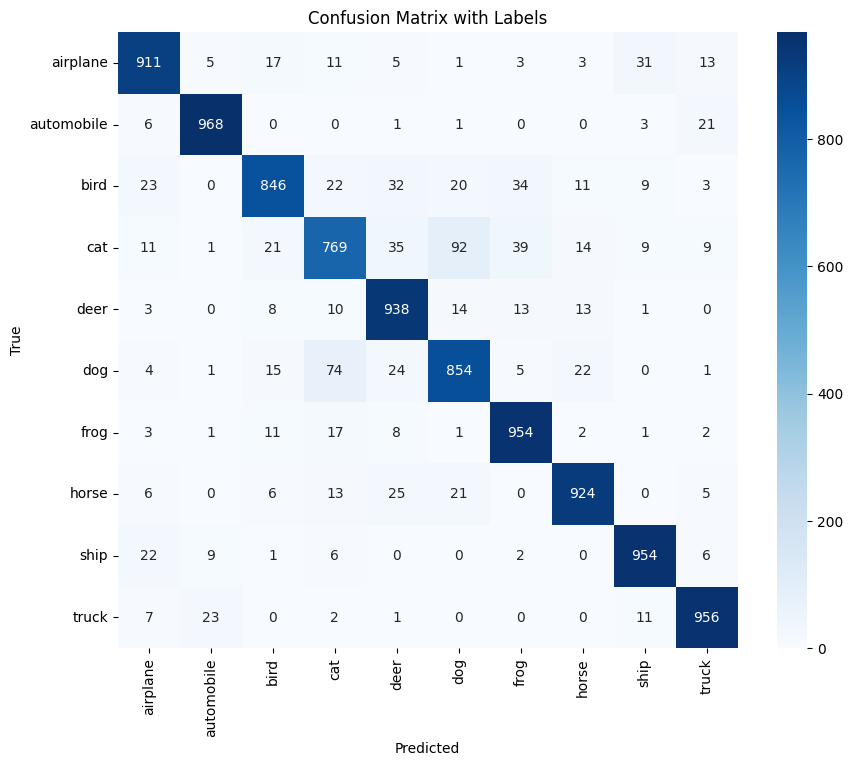

In [21]:
cm = confusion_matrix(y_true, y_pred)
class_names = test_loader.dataset.classes
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Labels')
cm_figure_labeled = plt.gcf()
plt.show()

wandb.log({"test/confusion_matrix": wandb.Image(cm_figure_labeled)})

In [22]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
test/acc,▁
test/airplane_f1-score,▁
test/airplane_precision,▁
test/airplane_recall,▁
test/automobile_f1-score,▁
test/automobile_precision,▁
test/automobile_recall,▁
test/bird_f1-score,▁
test/bird_precision,▁
test/bird_recall,▁
